# 1. Analise Descritiva da Adesão de Seguros

### Importação das bibliotecas

In [1]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
sns.set()

from scipy.cluster.hierarchy import dendrogram, linkage


import pickle

In [2]:
# ================
# Lista global de cores para as categorias e gráficos
# ================
lista_cores = ['#3374CD', '#4E9DA7', '#C94591', '#DC7025', '#2F3BA4',
               '#E66981', '#C02EC8', '#522FA7', '#C70039', '#117A65',
              # incluir mais cores, no momento só vou repetir a lista de cima
              '#3374CD', '#4E9DA7', '#C94591', '#DC7025', '#2F3BA4',
               '#E66981', '#C02EC8', '#522FA7', '#C70039', '#117A65',
               '#3374CD', '#4E9DA7', '#C94591', '#DC7025', '#2F3BA4',
               '#E66981', '#C02EC8', '#522FA7', '#C70039', '#117A65'
              ]

In [7]:
#Import da base de dados
df = pd.read_excel('ADESAO_MES.xlsx')
df.head()

,ANO_MES_PORTFOLIO,DAT_DATA_REFERENCIA,ANO_PORTFOLIO,TRI_PORTFOLIO,ID_ADESAO,DSC_CICLO_SEGURO,DSC_CICLO_SEGURO_ABERTURA,FLG_PORTFOLIO_SEGUROS,FLG_ADESAO_NOVA,DSC_EMPRESA,...,NUM_IDADE,DSC_PROFISSAO,DSC_DOMINIO_EMAIL,DSC_GENERO_AJUSTADO,NUM_CEP,SIG_UF,DSC_UF,SIG_REGIAO,DSC_REGIAO,FLG_CANCEL_M2
0,202504,2025-04-30,2025,2,1,01| FIDELIZACAO,01| Seguro Novo e Conta Nova,1,1,ATACADÃO,...,26,NaN,GMAIL.COM,FEMININO,78000000.0,MT,MATO GROSSO,CO,CENTRO-OESTE,NaN
1,202504,2025-04-30,2025,2,2,01| FIDELIZACAO,01| Seguro Novo e Conta Nova,1,1,ATACADÃO,...,53,NaN,GMAIL.COM,FEMININO,4423070.0,SP,SÃO PAULO,SE,SUDESTE,NaN
2,202504,2025-04-30,2025,2,3,01| FIDELIZACAO,01| Seguro Novo e Conta Nova,1,1,ATACADÃO,...,36,NaN,GMAIL.COM,FEMININO,17000000.0,SP,SÃO PAULO,SE,SUDESTE,NaN
3,202503,2025-03-31,2025,1,4,01| FIDELIZACAO,01| Seguro Novo e Conta Nova,1,1,CARREFOUR,...,40,NaN,HOTMAIL.COM,FEMININO,21000000.0,RJ,RIO DE JANEIRO,SE,SUDESTE,1.0
4,202410,2024-10-31,2024,4,5,01| FIDELIZACAO,01| Seguro Novo e Conta Nova,1,1,ATACADÃO,...,40,NaN,GMAIL.COM,MASCULINO,2177000.0,SP,SÃO PAULO,SE,SUDESTE,1.0


In [8]:
cancelamento_por_safra = (
    df.groupby("ANO_MES_PORTFOLIO")["FLG_CANCEL_M2"]
    .agg(cancelamentos='sum', total='count')
    .assign(taxa_cancelamento=lambda x: x["cancelamentos"] / x["total"])
    .reset_index()
)


In [9]:
cancelamento_por_safra

,ANO_MES_PORTFOLIO,cancelamentos,total,taxa_cancelamento
0,202410,156.0,296,0.527027
1,202502,110.0,229,0.480349
2,202503,128.0,243,0.526749
3,202504,0.0,0,NaN


In [12]:
df_grouped = (
    df.groupby("ANO_MES_PORTFOLIO")
    .agg(
        ID_ADESAO=('ID_ADESAO', 'count'),
        CANCELAMENTOS=('FLG_CANCEL_M2', 'sum')
    )
    .assign(
        TAXA_CANCELAMENTO=lambda x: x['CANCELAMENTOS'] / x['ID_ADESAO']
    )
    .reset_index()
)

# Converter a coluna de data para string para facilitar o uso nos gráficos
df_grouped["ANO_MES_PORTFOLIO"] = df_grouped["ANO_MES_PORTFOLIO"].astype(str)


In [13]:
df_grouped

,ANO_MES_PORTFOLIO,ID_ADESAO,CANCELAMENTOS,TAXA_CANCELAMENTO
0,202410,296,156.0,0.527027
1,202502,229,110.0,0.480349
2,202503,243,128.0,0.526749
3,202504,232,0.0,0.000000


In [26]:
def plot_personalizado(
    df_grouped,
    cor_linha='#522FA7',
    cor_marcador='#522FA7',
    cor_texto='#414141',
    cor_grid='white',
    cor_borda_plot='white',
    cor_fundo_plot='white',
    salvar_como='grafico_adesoes.png',
    incluir_eixo_secundario=True
):
    import matplotlib.pyplot as plt
    import numpy as np

    x = np.arange(len(df_grouped))
    y_barras = df_grouped['ID_ADESAO'].values
    y_linha = df_grouped['TAXA_CANCELAMENTO'].values
    labels = df_grouped['ANO_MES_PORTFOLIO']

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo principal: barras
    bars = ax1.bar(x, y_barras, color=cor_marcador, alpha=0.6)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, color=cor_texto)
    ax1.set_xlabel('Ano/Mês da Adesão', color=cor_texto)
    ax1.set_ylabel('Quantidade de Adesões', color=cor_texto)
    ax1.set_ylim(bottom=0)
    ax1.set_title('Adesões e Taxa de Cancelamento por Safra', fontsize=14, loc='left', color=cor_texto)
    ax1.grid(True, color=cor_grid)
    ax1.set_facecolor(cor_fundo_plot)
    for spine in ax1.spines.values():
        spine.set_color(cor_borda_plot)

    # Rótulos nas barras (em milhar)
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(y_barras) * 0.015,
            f'{height/1000:.1f}k',
            ha='center',
            va='bottom',
            fontsize=9,
            color=cor_texto
        )

    # Eixo secundário: linha + rótulos
    if incluir_eixo_secundario:
        valid_idx = np.where((~np.isnan(y_linha)) & (y_linha > 0))[0]
        if len(valid_idx) > 0:
            last_valid_index = valid_idx[-1]
            x_valid = x[:last_valid_index + 1]
            y_valid = y_linha[:last_valid_index + 1]

            ax2 = ax1.twinx()
            ax2.plot(x_valid, y_valid, color=cor_linha, marker='o', linewidth=2)
            ax2.set_ylabel('Taxa de Cancelamento (M2)', color=cor_linha)
            ax2.tick_params(axis='y', labelcolor=cor_linha)
            ax2.set_ylim(0, np.nanmax(y_valid) * 1.2)

            # Rótulos na linha (%)
            for xi, yi in zip(x_valid, y_valid):
                ax2.text(
                    xi,
                    yi + np.nanmax(y_valid) * 0.02,
                    f'{yi*100:.1f}%',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    color=cor_linha
                )

    plt.tight_layout()
    plt.savefig(salvar_como, dpi=300, bbox_inches='tight')
    plt.show()


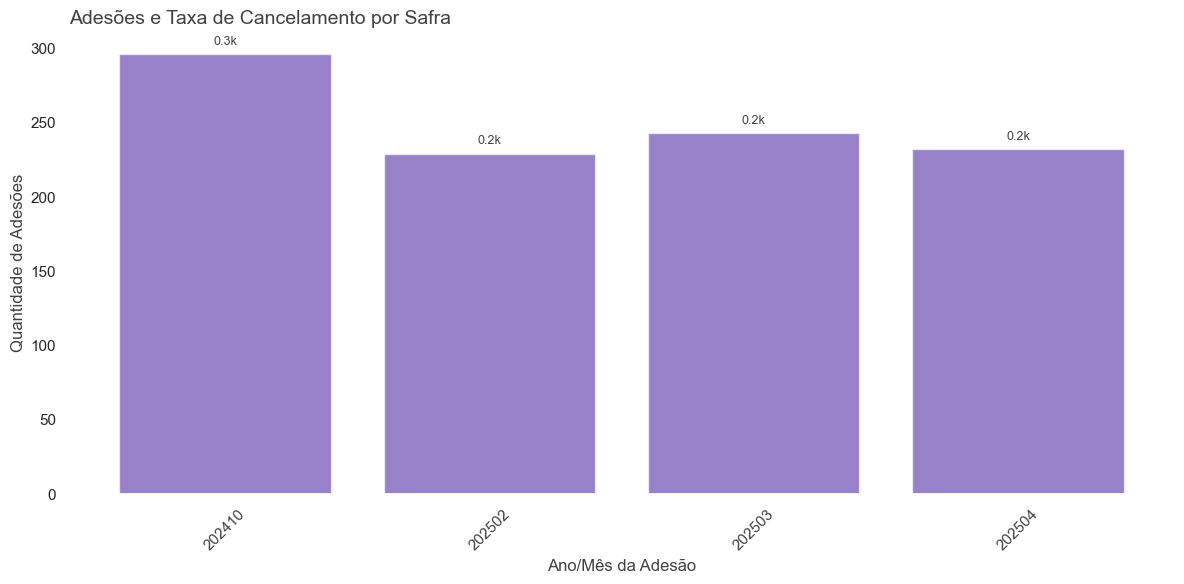

In [27]:
plot_personalizado(
    df_grouped=df_grouped,
    cor_linha='#522FA7',
    cor_marcador='#522FA7',
    cor_texto='#414141',
    cor_grid='white',
    cor_borda_plot='white',
    cor_fundo_plot='#FFFFFF',
    salvar_como='grafico_adesao.png',
    incluir_eixo_secundario=False
)


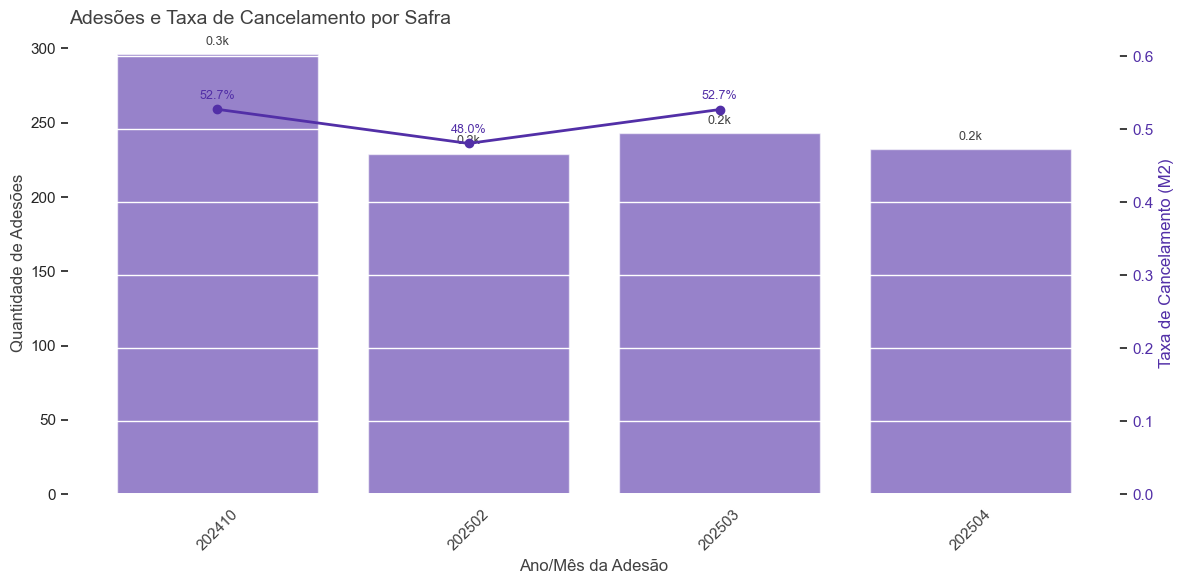

In [28]:
plot_personalizado(
    df_grouped=df_grouped,
    cor_linha='#522FA7',
    cor_marcador='#522FA7',
    cor_texto='#414141',
    cor_grid='white',
    cor_borda_plot='white',
    cor_fundo_plot='#FFFFFF',
    salvar_como='grafico_adesao.png',
    incluir_eixo_secundario=True
)


In [ ]:
# Comparativo Cancelamento e Adesao

In [35]:
def plot_subplots_variavel_categorica(
    df,
    variavel_categoria,
    lista_cores,
    colunas=2,
    cor_texto='#414141',
    cor_grid='#f3f3f3',
    cor_borda_plot='#414141',
    cor_fundo_plot='white',
    salvar_como=None
):
    if salvar_como is None:
        salvar_como = f'adesoes_cancelamentos_por_{variavel_categoria.lower()}.png'

    categorias = sorted(df[variavel_categoria].dropna().unique())
    qtd_categorias = len(categorias)
    if qtd_categorias > len(lista_cores):
        raise ValueError(f"Número de categorias ({qtd_categorias}) excede número de cores disponíveis ({len(lista_cores)}).")

    cores_utilizadas = {cat: lista_cores[i] for i, cat in enumerate(categorias)}
    linhas = math.ceil(qtd_categorias / colunas)

    fig, axes = plt.subplots(linhas, colunas * 2, figsize=(6 * colunas * 2, 4 * linhas))
    axes = axes.flatten()

    max_adesoes_global = (
        df.groupby([variavel_categoria, 'ANO_MES_PORTFOLIO'])['ID_ADESAO']
        .count().max() * 1.1
    )

    for i, (categoria, cor) in enumerate(cores_utilizadas.items()):
        df_categoria = df[df[variavel_categoria] == categoria]
        grupo = df_categoria.groupby("ANO_MES_PORTFOLIO").agg(
            ADESOES=('ID_ADESAO', 'count'),
            CANCELAMENTOS=('FLG_CANCEL_M2', 'sum')
        ).assign(
            TAXA_CANCELAMENTO=lambda x: 100 * x['CANCELAMENTOS'] / x['ADESOES']
        ).reset_index()

        grupo["ANO_MES_PORTFOLIO"] = grupo["ANO_MES_PORTFOLIO"].astype(str)
        x = np.arange(len(grupo))
        labels = grupo["ANO_MES_PORTFOLIO"]

        # Gráfico 1: Adesões
        y1 = grupo["ADESOES"].values
        coef1 = np.polyfit(x, y1, 1) if len(x) > 1 else [0, y1[0]]
        y1_trend = np.poly1d(coef1)(x)

        ax1 = axes[2 * i]
        ax1.plot(x, y1, color=cor, linewidth=2)
        ax1.scatter(x, y1, color=cor, edgecolors=cor, s=40, zorder=3)
        ax1.plot(x, y1_trend, color=cor, linestyle='--', linewidth=2, alpha=0.8)
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels, rotation=45, fontsize=9, color=cor_texto)
        ax1.set_title(f'{categoria} - Adesões', loc='left', fontsize=11, color=cor_texto)
        ax1.set_facecolor(cor_fundo_plot)
        ax1.set_ylim(0, max_adesoes_global)
        ax1.grid(True, color=cor_grid)
        for spine in ax1.spines.values():
            spine.set_color(cor_borda_plot)

        # Gráfico 2: Taxa de Cancelamento (%)
        y2 = grupo["TAXA_CANCELAMENTO"].values
        y2_valid_mask = (~np.isnan(y2)) & (y2 > 0)
        x_valid = x[y2_valid_mask]
        y2_valid = y2[y2_valid_mask]

        ax2 = axes[2 * i + 1]
        if len(x_valid) > 0:
            coef2 = np.polyfit(x_valid, y2_valid, 1) if len(x_valid) > 1 else [0, y2_valid[0]]
            y2_trend = np.poly1d(coef2)(x_valid)

            ax2.plot(x_valid, y2_valid, color=cor, linewidth=2)
            ax2.scatter(x_valid, y2_valid, color=cor, edgecolors=cor, s=40, zorder=3)
            ax2.plot(x_valid, y2_trend, color=cor, linestyle='--', linewidth=2, alpha=0.8)

        ax2.set_xticks(x)
        ax2.set_xticklabels(labels, rotation=45, fontsize=9, color=cor_texto)
        ax2.set_title(f'{categoria} - Taxa Cancelamento (%)', loc='left', fontsize=11, color=cor_texto)
        ax2.set_facecolor(cor_fundo_plot)
        ax2.set_ylim(0, 100)
        ax2.grid(True, color=cor_grid)
        for spine in ax2.spines.values():
            spine.set_color(cor_borda_plot)

    for j in range(2 * i + 2, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Evolução de Adesões e Cancelamentos por Categoria: {variavel_categoria}', fontsize=16, color=cor_texto)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(salvar_como, dpi=300, bbox_inches='tight')
    plt.show()

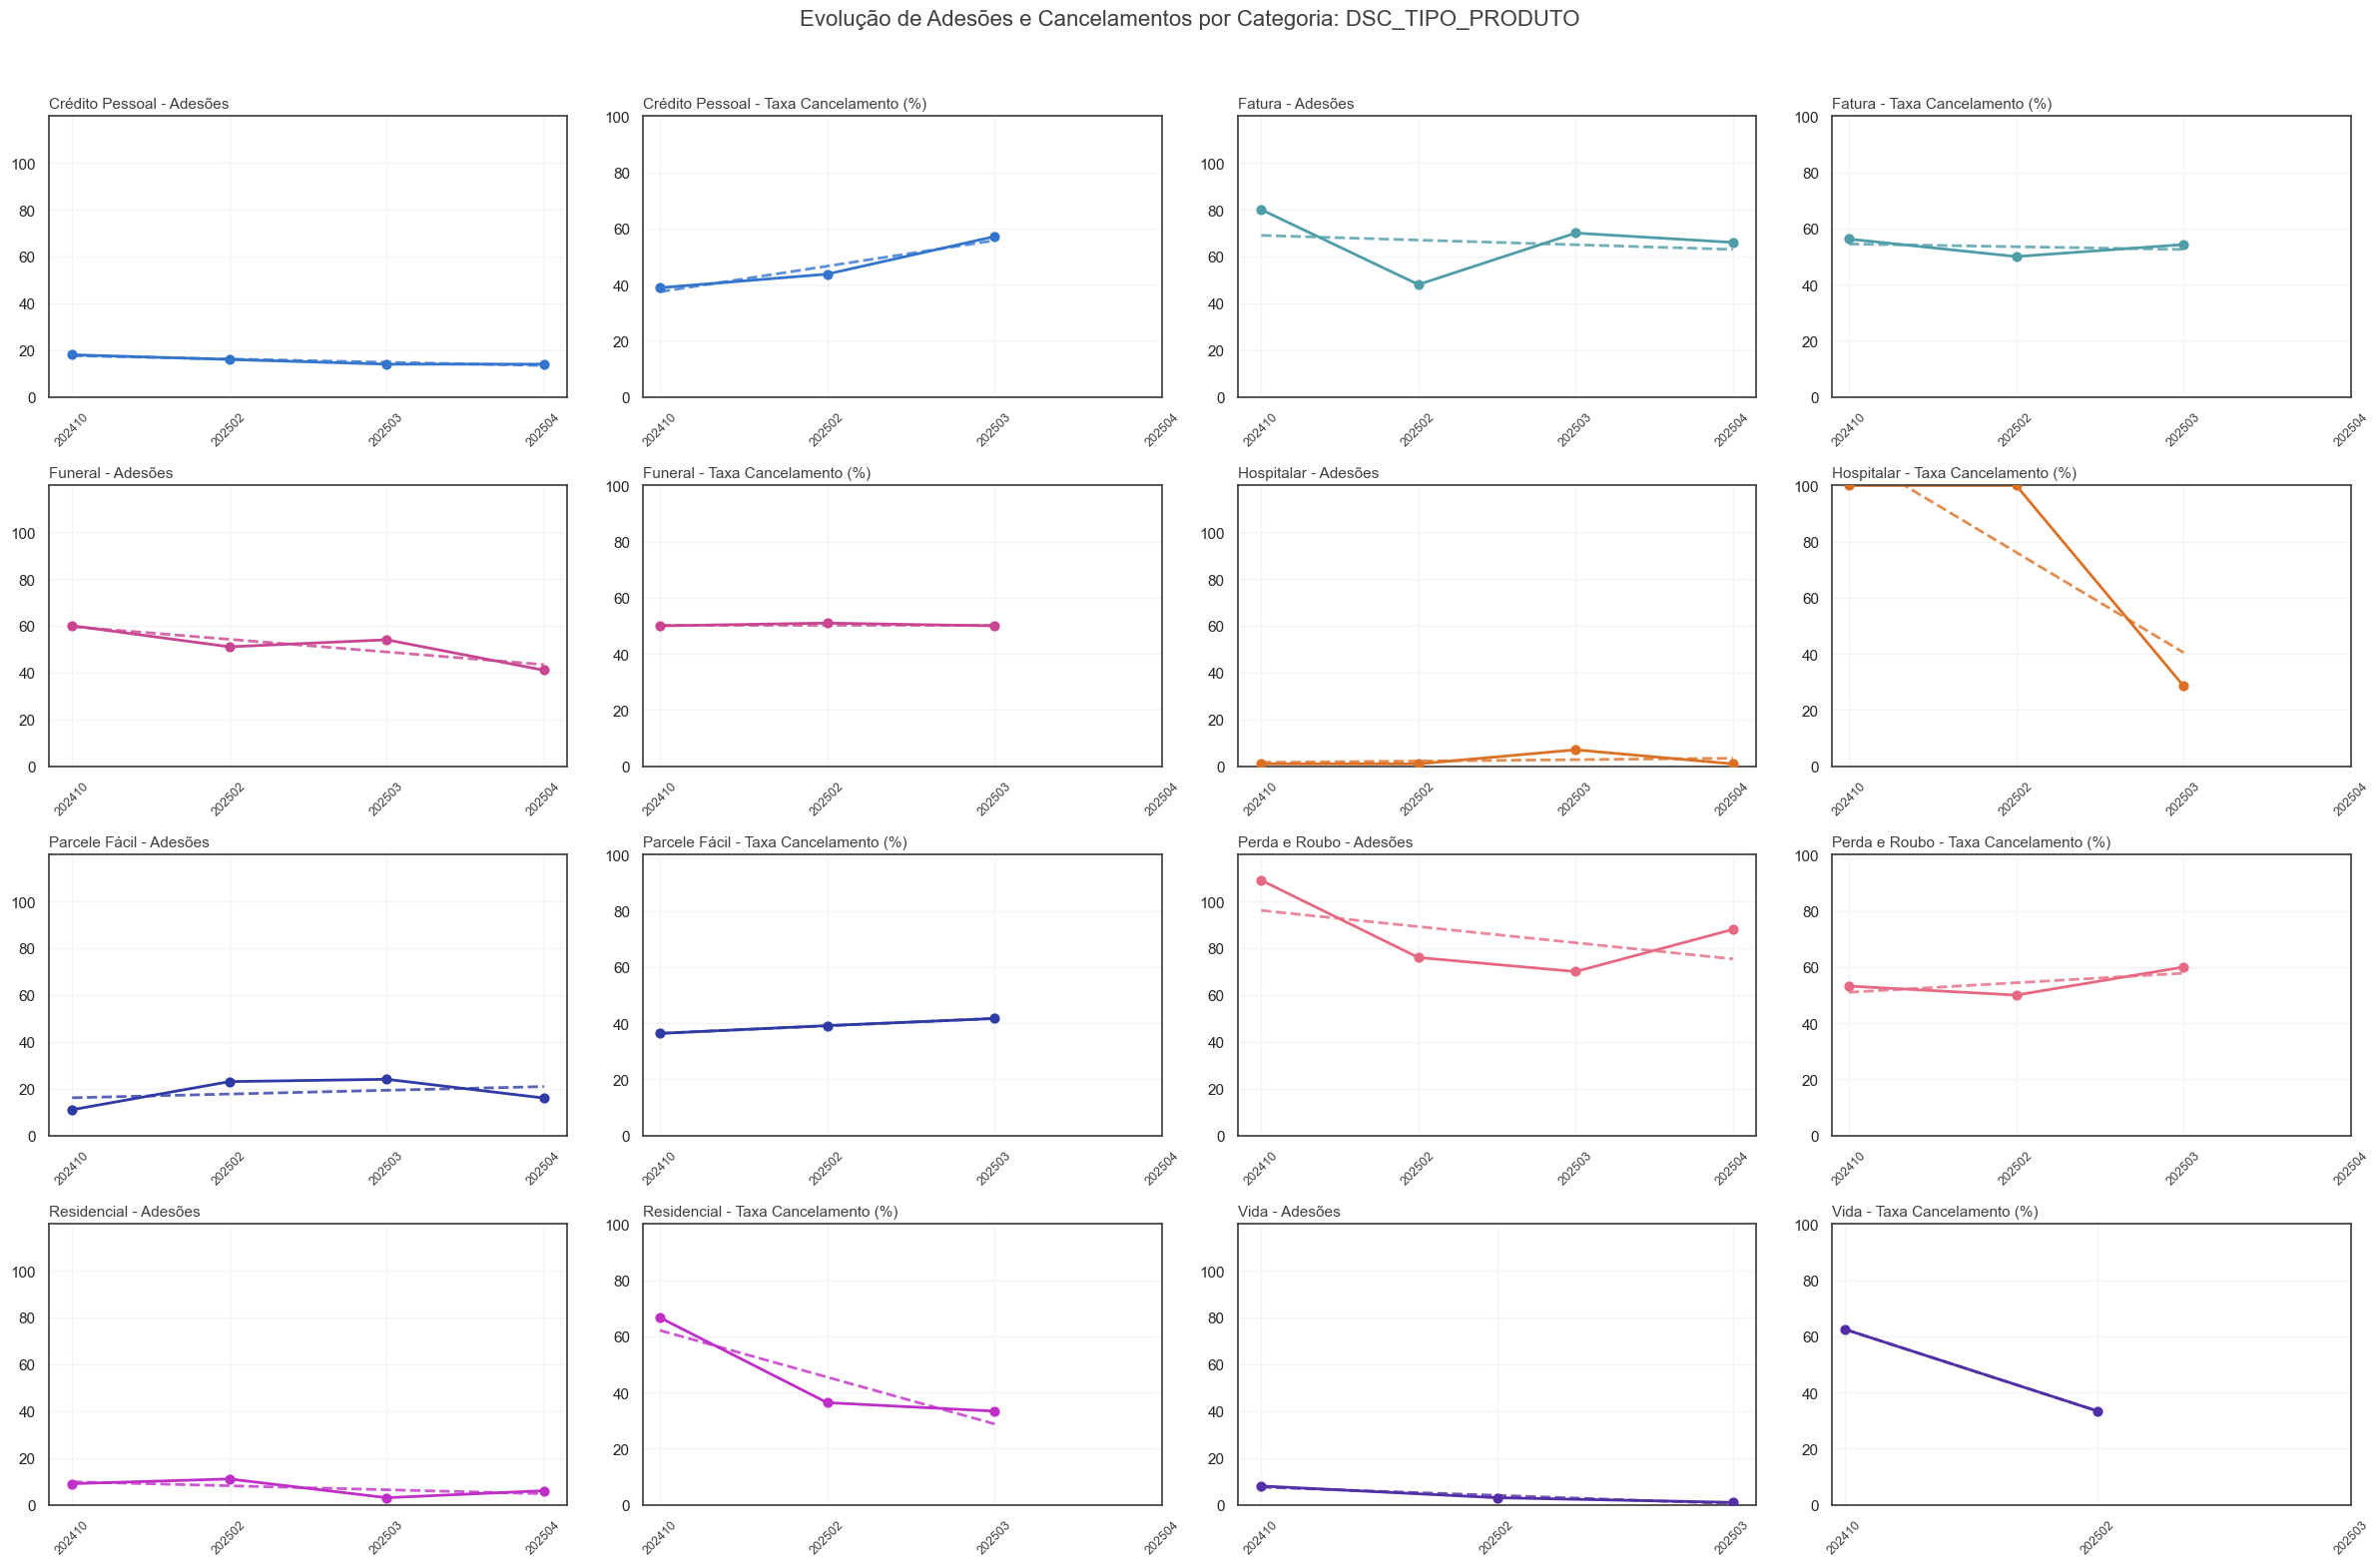

In [36]:
plot_subplots_variavel_categorica(
    df=df,
    variavel_categoria='DSC_TIPO_PRODUTO',  # substitua pela variável desejada
    lista_cores=lista_cores
)


In [44]:
def plot_subplots_variavel_categorica(
    df: pd.DataFrame,
    variavel_categoria: str,
    lista_cores: lista_cores,
    colunas: int = 2,
    cor_texto: str = '#414141',
    cor_grid: str = '#f3f3f3',
    cor_borda_plot: str = '#414141',
    cor_fundo_plot: str = 'white',
    salvar_como: str = None
):
    if salvar_como is None:
        salvar_como = f'adesoes_cancelamentos_por_{variavel_categoria.lower()}.png'

    categorias = sorted(df[variavel_categoria].dropna().unique())
    qtd_categorias = len(categorias)
    if qtd_categorias > len(lista_cores):
        raise ValueError(f"Número de categorias ({qtd_categorias}) excede número de cores disponíveis ({len(lista_cores)}).")

    cores_utilizadas = {cat: lista_cores[i] for i, cat in enumerate(categorias)}
    linhas = math.ceil(qtd_categorias / colunas)

    fig, axes = plt.subplots(linhas, colunas * 2, figsize=(6 * colunas * 2, 4 * linhas))
    axes = axes.flatten()

    max_adesoes_global = (
        df.groupby([variavel_categoria, 'ANO_MES_PORTFOLIO'])['ID_ADESAO']
        .count().max() * 1.1
    )

    resumo = []

    for i, (categoria, cor) in enumerate(cores_utilizadas.items()):
        df_categoria = df[df[variavel_categoria] == categoria]
        grupo = df_categoria.groupby("ANO_MES_PORTFOLIO").agg(
            ADESOES=('ID_ADESAO', 'count'),
            CANCELAMENTOS=('FLG_CANCEL_M2', 'sum')
        ).assign(
            TAXA_CANCELAMENTO=lambda x: 100 * x['CANCELAMENTOS'] / x['ADESOES']
        ).reset_index()

        grupo["ANO_MES_PORTFOLIO"] = grupo["ANO_MES_PORTFOLIO"].astype(str)
        x = np.arange(len(grupo))
        labels = grupo["ANO_MES_PORTFOLIO"]

        # Gráfico 1: Adesões
        y1 = grupo["ADESOES"].values
        coef1 = np.polyfit(x, y1, 1) if len(x) > 1 else [0, y1[0]]
        y1_trend = np.poly1d(coef1)(x)

        ax1 = axes[2 * i]
        ax1.plot(x, y1, color=cor, linewidth=2)
        ax1.scatter(x, y1, color=cor, edgecolors=cor, s=40, zorder=3)
        ax1.plot(x, y1_trend, color=cor, linestyle='--', linewidth=2, alpha=0.8)
        ax1.text(x[0], y1[0], f'{int(y1[0])}', ha='center', va='bottom', fontsize=9)
        ax1.text(x[-1], y1[-1], f'{int(y1[-1])}', ha='center', va='bottom', fontsize=9)
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels, rotation=45, fontsize=9, color=cor_texto)
        ax1.set_title(f'{categoria} - Adesões', loc='left', fontsize=11, color=cor_texto)
        ax1.set_facecolor(cor_fundo_plot)
        ax1.set_ylim(0, max_adesoes_global)
        ax1.grid(True, color=cor_grid)
        for spine in ax1.spines.values():
            spine.set_color(cor_borda_plot)

        # Gráfico 2: Taxa de Cancelamento (%)
        y2 = grupo["TAXA_CANCELAMENTO"].values
        y2_valid_mask = (~np.isnan(y2)) & (y2 > 0)
        x_valid = x[y2_valid_mask]
        y2_valid = y2[y2_valid_mask]

        ax2 = axes[2 * i + 1]
        if len(x_valid) > 0:
            coef2 = np.polyfit(x_valid, y2_valid, 1) if len(x_valid) > 1 else [0, y2_valid[0]]
            y2_trend = np.poly1d(coef2)(x_valid)

            ax2.plot(x_valid, y2_valid, color=cor, linewidth=2)
            ax2.scatter(x_valid, y2_valid, color=cor, edgecolors=cor, s=40, zorder=3)
            ax2.plot(x_valid, y2_trend, color=cor, linestyle='--', linewidth=2, alpha=0.8)
            ax2.text(x_valid[0], y2_valid[0], f'{y2_valid[0]:.1f}%', ha='center', va='bottom', fontsize=9)
            ax2.text(x_valid[-1], y2_valid[-1], f'{y2_valid[-1]:.1f}%', ha='center', va='bottom', fontsize=9)

        ax2.set_xticks(x)
        ax2.set_xticklabels(labels, rotation=45, fontsize=9, color=cor_texto)
        ax2.set_title(f'{categoria} - Taxa Cancelamento (%)', loc='left', fontsize=11, color=cor_texto)
        ax2.set_facecolor(cor_fundo_plot)
        ax2.set_ylim(0, 100)
        ax2.grid(True, color=cor_grid)
        for spine in ax2.spines.values():
            spine.set_color(cor_borda_plot)

        # ✅ Correção no merge: forçar ambos como string
        total_mes = df.groupby("ANO_MES_PORTFOLIO")["ID_ADESAO"].count().rename("TOTAL_ADESOES_MES").reset_index()
        total_mes["ANO_MES_PORTFOLIO"] = total_mes["ANO_MES_PORTFOLIO"].astype(str)
        grupo = grupo.merge(total_mes, on="ANO_MES_PORTFOLIO", how="left")
        grupo["PCT_ADESOES"] = grupo["ADESOES"] / grupo["TOTAL_ADESOES_MES"] * 100
        grupo["PCT_CANCELAMENTOS"] = grupo["CANCELAMENTOS"] / grupo["TOTAL_ADESOES_MES"] * 100
        grupo["CATEGORIA"] = categoria
        resumo.append(grupo[[
            "ANO_MES_PORTFOLIO", "CATEGORIA", "ADESOES", "PCT_ADESOES",
            "CANCELAMENTOS", "PCT_CANCELAMENTOS", "TAXA_CANCELAMENTO"
        ]])

    for j in range(2 * i + 2, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Evolução de Adesões e Cancelamentos por Categoria: {variavel_categoria}', fontsize=16, color=cor_texto)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(salvar_como, dpi=300, bbox_inches='tight')
    plt.show()

    resumo_df = pd.concat(resumo).reset_index(drop=True)
    return resumo_df


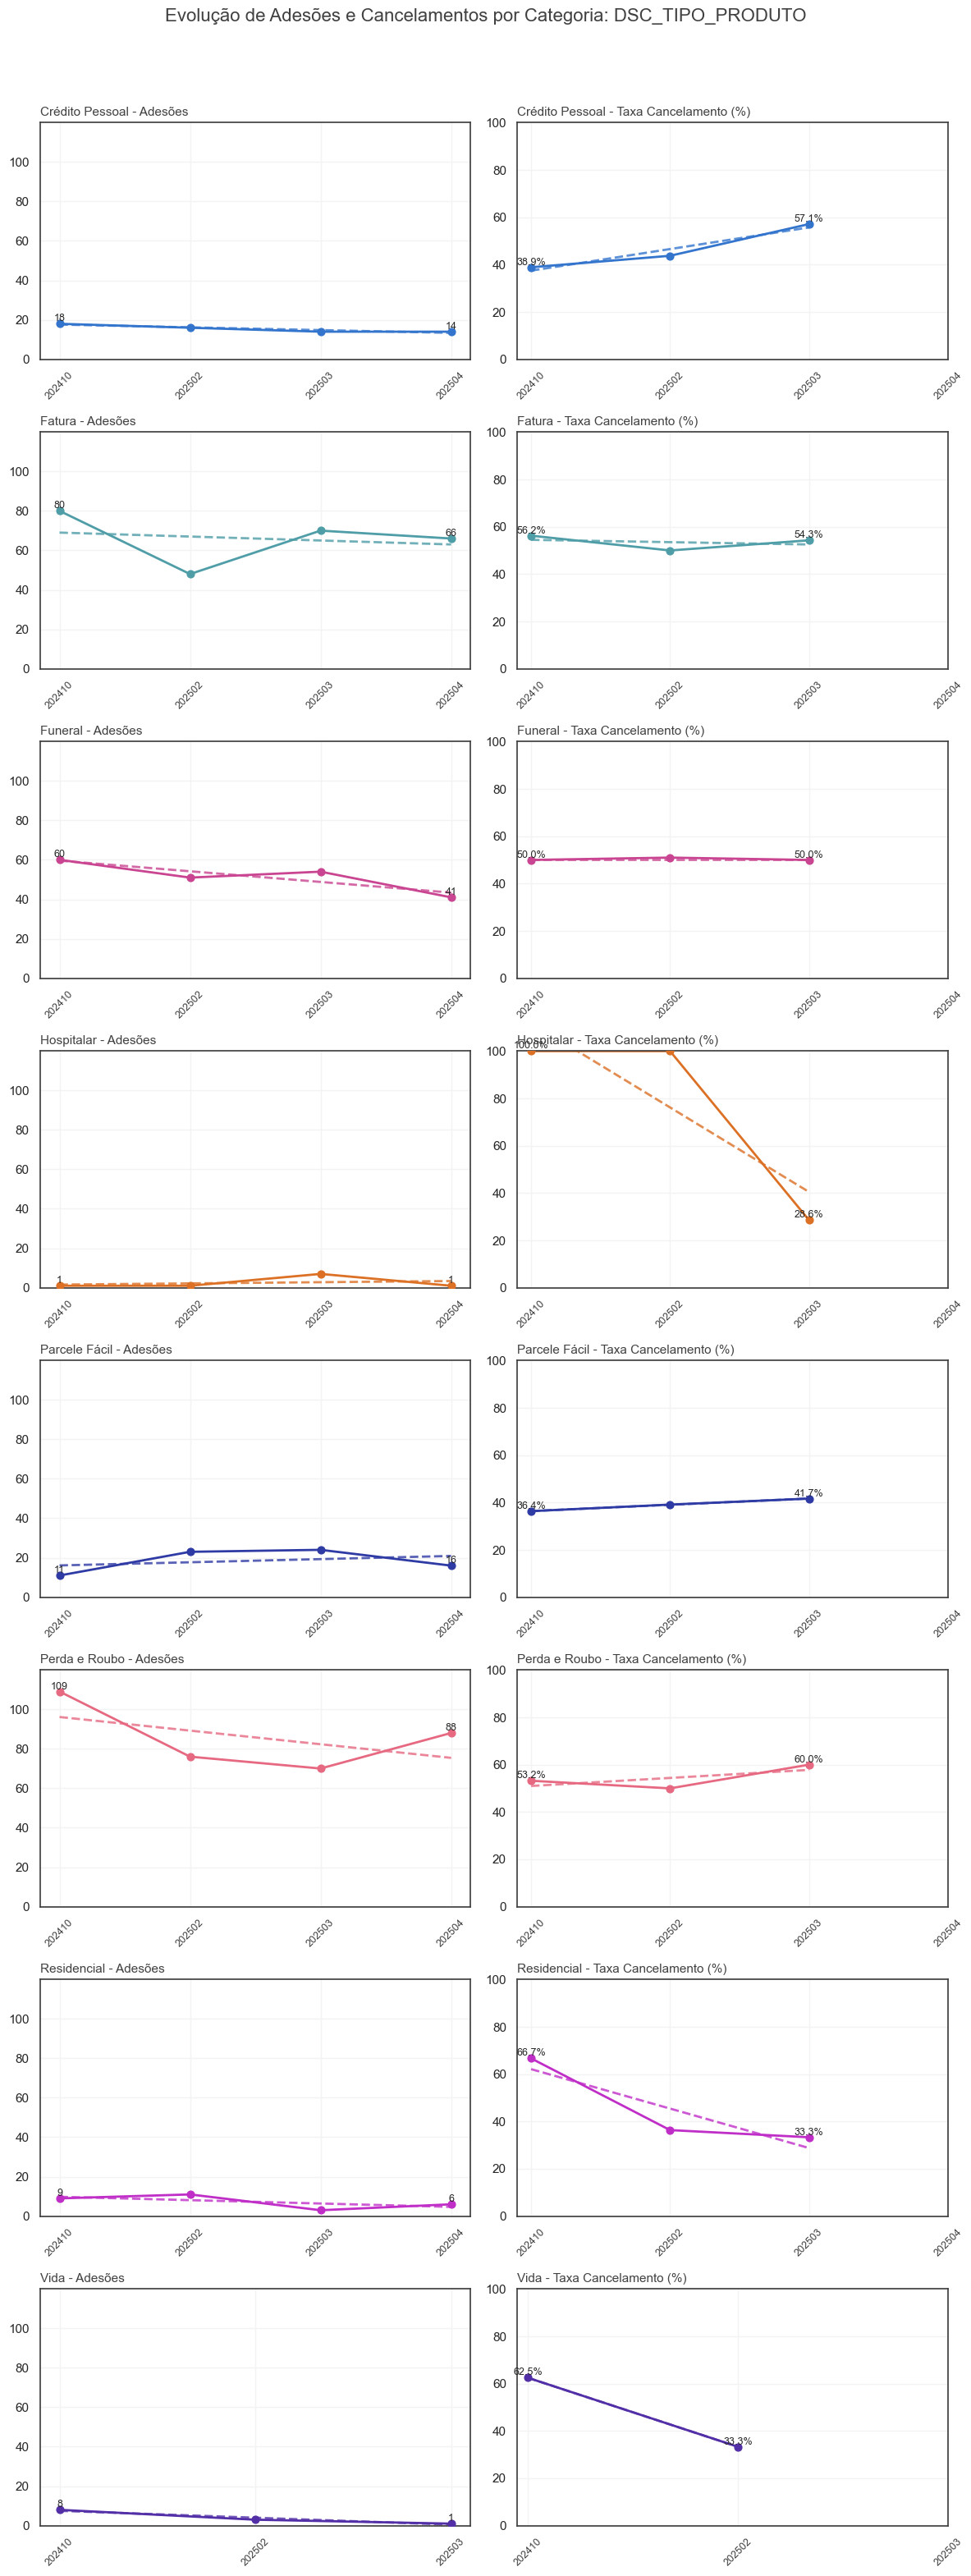

,ANO_MES_PORTFOLIO,CATEGORIA,ADESOES,PCT_ADESOES,CANCELAMENTOS,PCT_CANCELAMENTOS,TAXA_CANCELAMENTO
0,202410,Crédito Pessoal,18,6.081081,7.0,2.364865,38.888889
1,202502,Crédito Pessoal,16,6.986900,7.0,3.056769,43.750000
2,202503,Crédito Pessoal,14,5.761317,8.0,3.292181,57.142857
3,202504,Crédito Pessoal,14,6.034483,0.0,0.000000,0.000000
4,202410,Fatura,80,27.027027,45.0,15.202703,56.250000
5,202502,Fatura,48,20.960699,24.0,10.480349,50.000000
6,202503,Fatura,70,28.806584,38.0,15.637860,54.285714
7,202504,Fatura,66,28.448276,0.0,0.000000,0.000000
8,202410,Funeral,60,20.270270,30.0,10.135135,50.000000
9,202502,Funeral,51,22.270742,26.0,11.353712,50.980392


In [50]:
variavel = "DSC_TIPO_PRODUTO"  # ou qualquer outra variável usada
resumo_df.to_excel(f"resumo_{variavel.lower()}.xlsx", index=False)
plot_subplots_variavel_categorica(
    df=df,
    variavel_categoria=variavel,
    lista_cores=lista_cores,
    colunas=1
)
resumo_df

In [72]:
def resumo_por_safra_categoria(
    df: pd.DataFrame,
    safra: str,
    variavel_categoria: str,
    salvar_excel: bool = False,
    nome_arquivo: str = None
) -> pd.DataFrame:
    # Filtrar pela safra escolhida
    df_safra = df[df["ANO_MES_PORTFOLIO"].astype(str) == str(safra)].copy()

    # Totais da safra
    total_adesoes = df_safra["ID_ADESAO"].count()
    total_cancelamentos = df_safra["FLG_CANCEL_M2"].sum()
    taxa_cancelamento_total = round(100 * total_cancelamentos / total_adesoes, 2) if total_adesoes > 0 else 0.0

    # Tabela por categoria
    grupo = df_safra.groupby(variavel_categoria).agg(
        ADESOES=('ID_ADESAO', 'count'),
        CANCELAMENTOS=('FLG_CANCEL_M2', 'sum')
    ).assign(
        PCT_ADESOES=lambda x: round(100 * x['ADESOES'] / total_adesoes, 2),
        PCT_CANCELAMENTOS=lambda x: round(100 * x['CANCELAMENTOS'] / total_cancelamentos, 2) if total_cancelamentos > 0 else 0,
        TAXA_CANCELAMENTO=lambda x: round(100 * x['CANCELAMENTOS'] / x['ADESOES'], 2)
    ).reset_index()

    # Linha total
    linha_total = pd.DataFrame([{
        variavel_categoria: str(safra),
        'ADESOES': total_adesoes,
        'PCT_ADESOES': 100.00,
        'CANCELAMENTOS': total_cancelamentos,
        'PCT_CANCELAMENTOS': 100.00,
        'TAXA_CANCELAMENTO': f'{taxa_cancelamento_total:.2f}'
    }])

    # Combinar total + grupo
    resultado = pd.concat([linha_total, grupo], ignore_index=True)

    # Salvar como Excel, se desejado
    if salvar_excel:
        if nome_arquivo is None:
            nome_arquivo = f"resumo_{variavel_categoria.lower()}_{safra}.xlsx"
        resultado.to_excel(nome_arquivo, index=False)

    # Print taxa total
    print(f'Taxa total de cancelamento da safra {safra}: {taxa_cancelamento_total:.2f}%')
    return resultado

In [74]:
resumo_por_safra_categoria(
    df=df,
    safra="202410",
    variavel_categoria="DSC_TIPO_PRODUTO",
    salvar_excel=True  # ou False se quiser só visualizar
)

Taxa total de cancelamento da safra 202410: 52.70%


,DSC_TIPO_PRODUTO,ADESOES,PCT_ADESOES,CANCELAMENTOS,PCT_CANCELAMENTOS,TAXA_CANCELAMENTO
0,202410,296,100.00,156.0,100.00,52.70
1,Crédito Pessoal,18,6.08,7.0,4.49,38.89
2,Fatura,80,27.03,45.0,28.85,56.25
3,Funeral,60,20.27,30.0,19.23,50.0
4,Hospitalar,1,0.34,1.0,0.64,100.0
5,Parcele Fácil,11,3.72,4.0,2.56,36.36
6,Perda e Roubo,109,36.82,58.0,37.18,53.21
7,Residencial,9,3.04,6.0,3.85,66.67
8,Vida,8,2.70,5.0,3.21,62.5


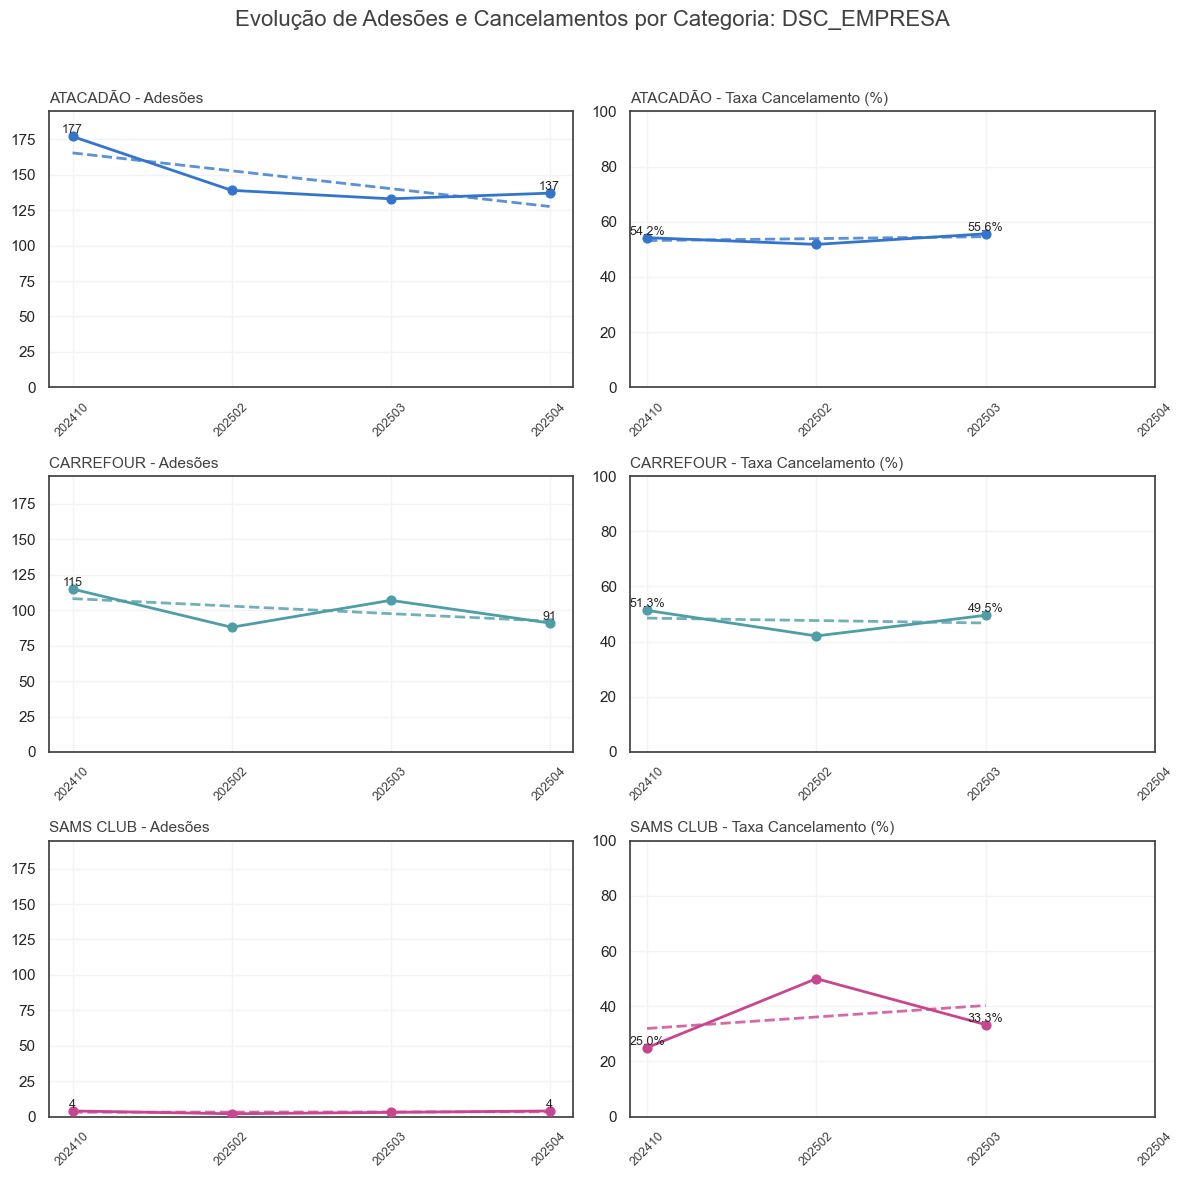

""


In [75]:
variavel = "DSC_EMPRESA"  # ou qualquer outra variável usada
resumo_df.to_excel(f"resumo_{variavel.lower()}.xlsx", index=False)
plot_subplots_variavel_categorica(
    df=df,
    variavel_categoria=variavel,
    lista_cores=lista_cores,
    colunas=1
)
resumo_df

In [77]:
resumo_por_safra_categoria(
    df=df,
    safra="202410",
    variavel_categoria="DSC_EMPRESA",
    salvar_excel=True  # ou False se quiser só visualizar
)

Taxa total de cancelamento da safra 202410: 52.70%


,DSC_EMPRESA,ADESOES,PCT_ADESOES,CANCELAMENTOS,PCT_CANCELAMENTOS,TAXA_CANCELAMENTO
0,202410,296,100.00,156.0,100.00,52.70
1,ATACADÃO,177,59.80,96.0,61.54,54.24
2,CARREFOUR,115,38.85,59.0,37.82,51.3
3,SAMS CLUB,4,1.35,1.0,0.64,25.0


In [82]:

def plot_barras_empilhadas_adesao_cancelamento_100pct(
    df,
    variaveis_categoricas,
    lista_cores,
    colunas: int = 2,
    cor_texto='#414141',
    salvar_como='comparativo_adesao_cancelamento.png'
):
    linhas = math.ceil(len(variaveis_categoricas) / colunas)
    fig, axes = plt.subplots(linhas, colunas * 2, figsize=(7 * colunas * 2, 5 * linhas))
    axes = axes.flatten()

    for idx, var in enumerate(variaveis_categoricas):
        # Adesões
        adesao_group = df.groupby([df['ANO_MES_PORTFOLIO'], df[var]])['ID_ADESAO'].count().reset_index()
        adesao_pivot = adesao_group.pivot(index='ANO_MES_PORTFOLIO', columns=var, values='ID_ADESAO').fillna(0)
        adesao_pct = adesao_pivot.div(adesao_pivot.sum(axis=1), axis=0) * 100

        categorias = adesao_pct.columns.tolist()
        if len(categorias) > len(lista_cores):
            raise ValueError(f"Número de categorias em {var} excede o número de cores disponíveis.")
        cores_dict = {cat: lista_cores[i] for i, cat in enumerate(categorias)}

        adesao_pct.plot(
            kind='bar',
            stacked=True,
            ax=axes[2 * idx],
            color=[cores_dict[cat] for cat in categorias],
            width=0.9
        )
        axes[2 * idx].set_title(f'{var} - Adesões', loc='left', fontsize=11, color=cor_texto)
        axes[2 * idx].set_ylabel('Percentual (%)')
        axes[2 * idx].set_ylim(0, 100)
        axes[2 * idx].legend([], frameon=False)
        axes[2 * idx].tick_params(axis='x', rotation=45)
        axes[2 * idx].grid(axis='y', linestyle='--', alpha=0.4)

        # Cancelamentos
        df_cancel = df[df['FLG_CANCEL_M2'] == 1]
        cancel_group = df_cancel.groupby([df_cancel['ANO_MES_PORTFOLIO'], df_cancel[var]])['ID_ADESAO'].count().reset_index()
        cancel_pivot = cancel_group.pivot(index='ANO_MES_PORTFOLIO', columns=var, values='ID_ADESAO').fillna(0)
        cancel_pct = cancel_pivot.div(cancel_pivot.sum(axis=1), axis=0) * 100

        cancel_pct = cancel_pct.reindex(columns=adesao_pct.columns, fill_value=0)

        cancel_pct.plot(
            kind='bar',
            stacked=True,
            ax=axes[2 * idx + 1],
            color=[cores_dict[cat] for cat in categorias],
            width=0.9
        )
        axes[2 * idx + 1].set_title(f'{var} - Cancelamentos', loc='left', fontsize=11, color=cor_texto)
        axes[2 * idx + 1].set_ylabel('Percentual (%)')
        axes[2 * idx + 1].set_ylim(0, 100)
        axes[2 * idx + 1].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[2 * idx + 1].tick_params(axis='x', rotation=45)
        axes[2 * idx + 1].grid(axis='y', linestyle='--', alpha=0.4)

    # Eixos não usados
    for i in range(2 * len(variaveis_categoricas), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(salvar_como, dpi=300, bbox_inches='tight')
    plt.show()

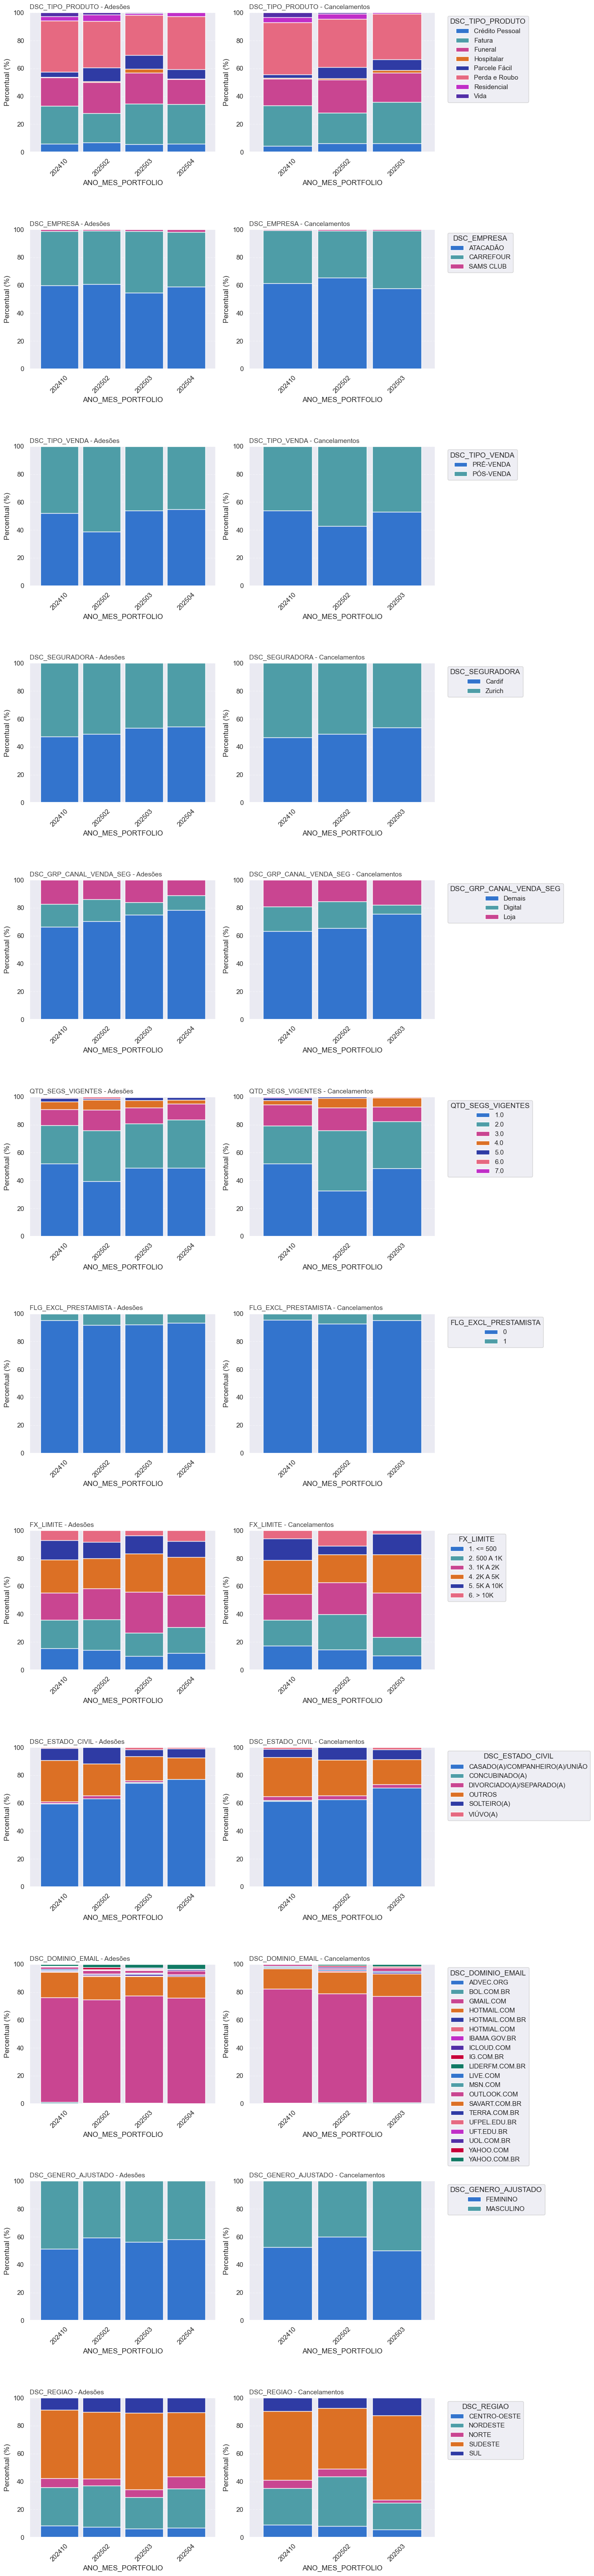

In [83]:
variaveis_categoricas = [
    'DSC_TIPO_PRODUTO',
    'DSC_EMPRESA',
    'DSC_TIPO_VENDA',
    'DSC_SEGURADORA',
    'DSC_GRP_CANAL_VENDA_SEG',
    'QTD_SEGS_VIGENTES',
    'FLG_EXCL_PRESTAMISTA',

    'FX_LIMITE',
    'DSC_ESTADO_CIVIL',

    'DSC_DOMINIO_EMAIL',
    'DSC_GENERO_AJUSTADO',
    'DSC_REGIAO'
]

plot_barras_empilhadas_adesao_cancelamento_100pct(
    df=df,
    variaveis_categoricas=variaveis_categoricas,
    lista_cores=lista_cores,
    colunas =1,
    salvar_como='comparativo_adesao_cancelamento.png'
)


In [84]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# 2. Filtra apenas as colunas necessárias
df_model = df[variaveis_categoricas + ['FLG_CANCEL_M2']].dropna()

# 3. Separar variáveis X e y
X = df_model[variaveis_categoricas]
y = df_model['FLG_CANCEL_M2']

# 4. Pré-processador para One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), variaveis_categoricas)
    ]
)

In [86]:
# 5. Modelo: Árvore de decisão rasa (max_depth=4 para facilitar interpretação)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=4, random_state=42))
])

In [87]:
# 6. Treina o modelo
model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DSC_TIPO_PRODUTO',
                                                   'DSC_EMPRESA',
                                                   'DSC_TIPO_VENDA',
                                                   'DSC_SEGURADORA',
                                                   'DSC_GRP_CANAL_VENDA_SEG',
                                                   'QTD_SEGS_VIGENTES',
                                                   'FLG_EXCL_PRESTAMISTA',
                                                   'FX_LIMITE',
                                                   'DSC_ESTADO_CIVIL',
                                                   'DSC_DOMINIO_EMAIL',
                                                   'DSC_GENERO_AJUSTADO',
                                                   'DSC_REGIAO'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=4, random_state=42))])

In [88]:
# 7. Pega nomes das variáveis transformadas
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(variaveis_categoricas)


In [89]:
# 8. Importância das variáveis
importances = model.named_steps['classifier'].feature_importances_
importances_df = pd.DataFrame({
    'variavel': feature_names,
    'importancia': importances
})

In [90]:
# 9. Agrega importância por variável original
importances_df['variavel_original'] = importances_df['variavel'].str.extract(r'^([^\_]+)')
importancia_agregada = importances_df.groupby('variavel_original')['importancia'].sum().sort_values(ascending=False).reset_index()


C:\Users\g_mac\AppData\Local\Temp\ipykernel_996\3152373118.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


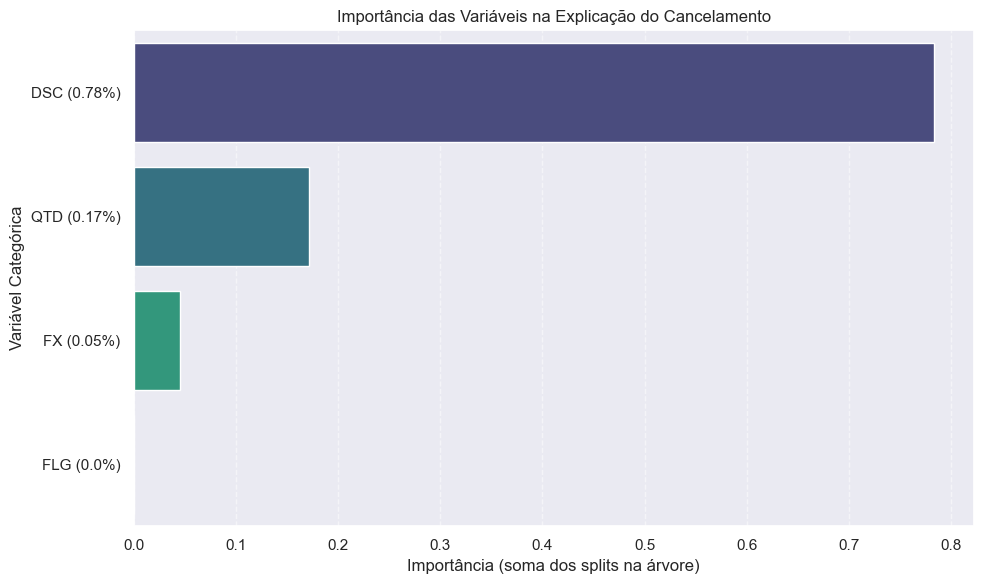

In [92]:
# 10. Visualização
# 1. Cria uma nova coluna de rótulo com nome + importância formatada
importancia_agregada['variavel_formatada'] = (
    importancia_agregada['variavel_original'] + 
    ' (' + importancia_agregada['importancia'].round(2).astype(str) + '%)'
)

# 2. Ordena para manter a visualização organizada
importancia_agregada = importancia_agregada.sort_values(by='importancia', ascending=False)

# 3. Plota com o novo rótulo
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importancia',
    y='variavel_formatada',  # Agora usa o campo formatado
    data=importancia_agregada,
    palette='viridis'
)

# 4. Ajustes estéticos
plt.title('Importância das Variáveis na Explicação do Cancelamento')
plt.xlabel('Importância (soma dos splits na árvore)')
plt.ylabel('Variável Categórica')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [93]:
importancia_agregada

,variavel_original,importancia,variavel_formatada
0,DSC,0.783001,DSC (0.78%)
1,QTD,0.171198,QTD (0.17%)
2,FX,0.045801,FX (0.05%)
3,FLG,0.000000,FLG (0.0%)


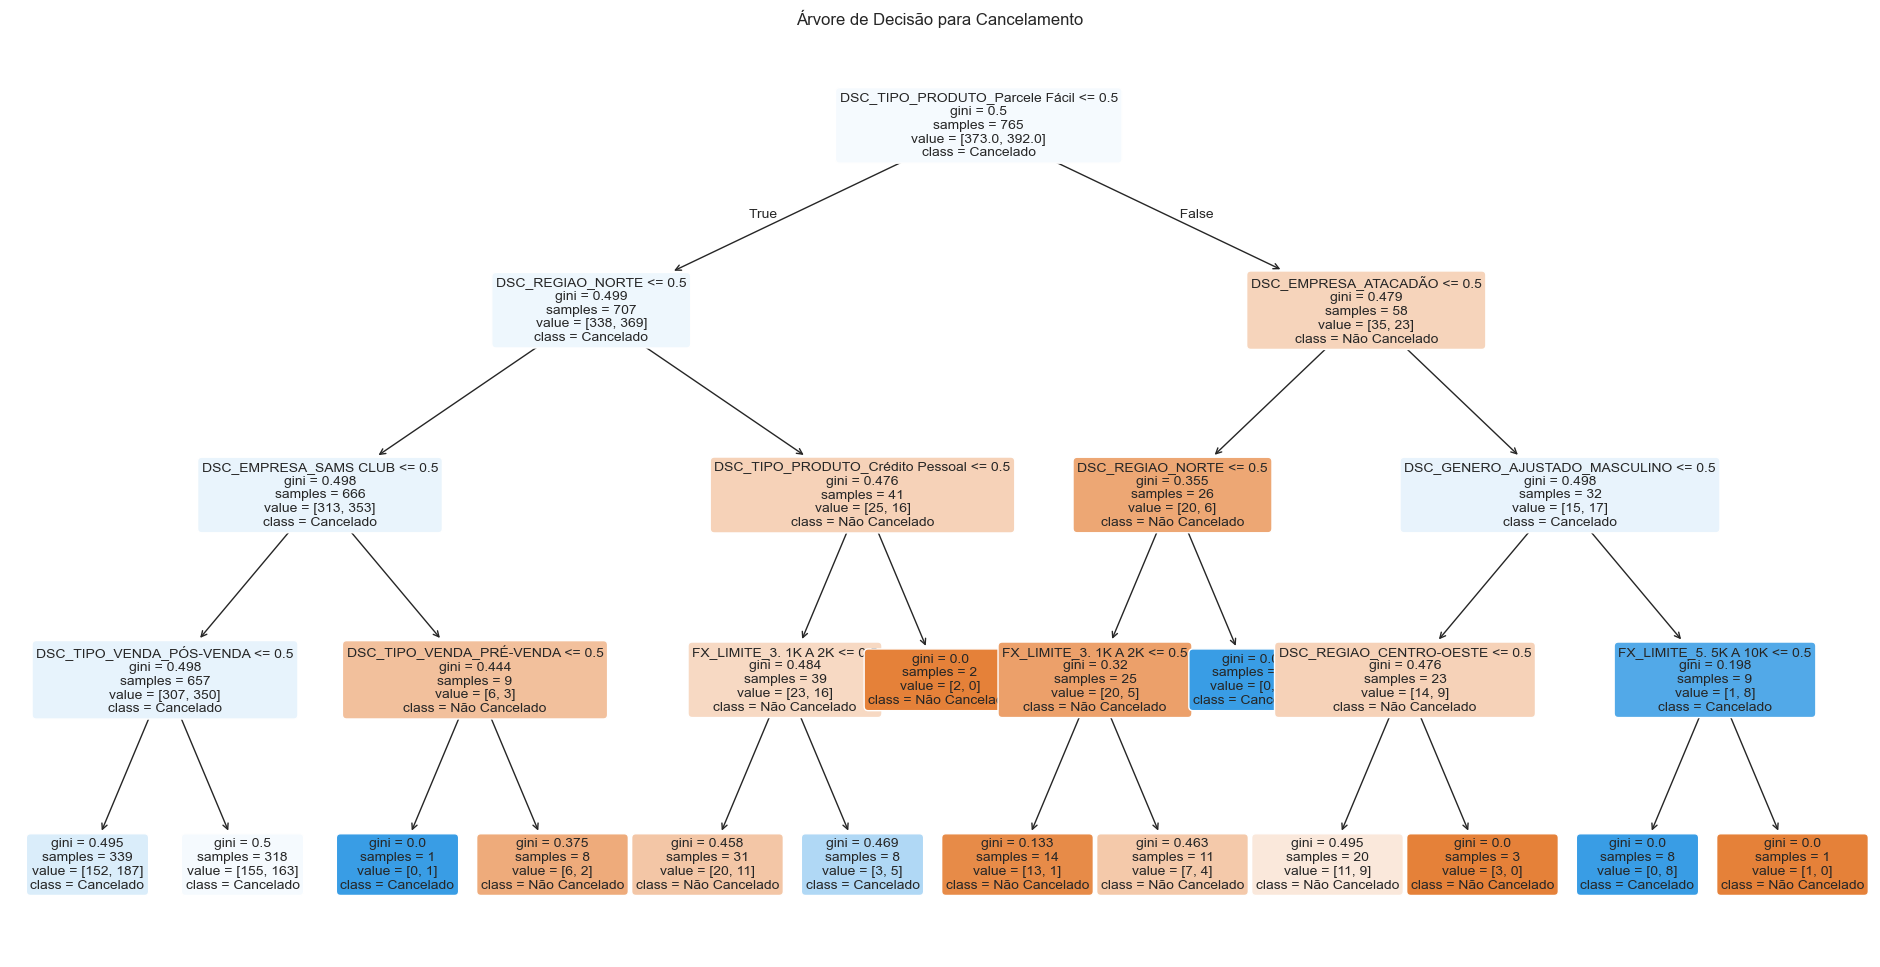

In [96]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

# 1. Defina variáveis categóricas e target
variaveis_categoricas = [
    'DSC_TIPO_PRODUTO', 'DSC_EMPRESA', 'DSC_TIPO_VENDA', 'DSC_SEGURADORA',
    'DSC_GRP_CANAL_VENDA_SEG', 'FLG_EXCL_PRESTAMISTA',
    'FX_LIMITE',  
    'DSC_GENERO_AJUSTADO', 'DSC_REGIAO'
]
target = 'FLG_CANCEL_M2'

# 2. Preparar dados
df_modelo = df[variaveis_categoricas + [target]].dropna()

X = df_modelo[variaveis_categoricas]
y = df_modelo[target]

# 3. Pipeline com OneHotEncoder e árvore de decisão
pipeline = Pipeline([
    ('encoder', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), variaveis_categoricas)
    ])),
    ('modelo', DecisionTreeClassifier(max_depth=4, random_state=42))
])

# 4. Treinar
pipeline.fit(X, y)

# 5. Visualizar árvore
modelo = pipeline.named_steps['modelo']
encoder = pipeline.named_steps['encoder']
ohe = encoder.named_transformers_['cat']
feature_names = ohe.get_feature_names_out(variaveis_categoricas)

plt.figure(figsize=(24, 12))
plot_tree(
    modelo,
    feature_names=feature_names,
    class_names=["Não Cancelado", "Cancelado"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Árvore de Decisão para Cancelamento")
plt.show()


AUC-ROC: 0.5787


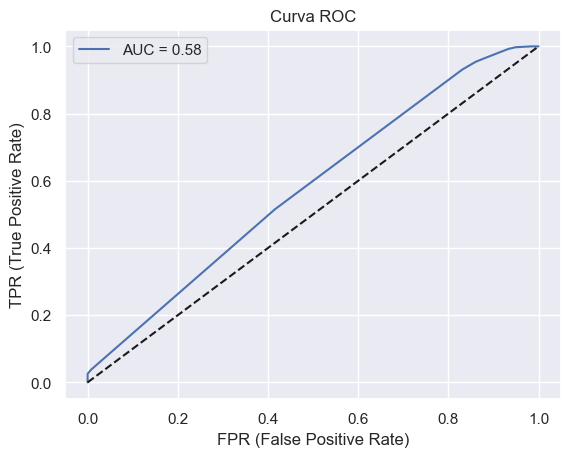

In [101]:
from sklearn.metrics import roc_auc_score

y_prob = pipeline.predict_proba(X)[:, 1]  # probabilidade da classe 1 (cancelado)
auc = roc_auc_score(y, y_prob)
print(f"AUC-ROC: {auc:.4f}")

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()



In [98]:
from scipy.stats import ks_2samp

y_prob = pipeline.predict_proba(X)[:, 1]
ks_stat, p_val = ks_2samp(y_prob[y == 1], y_prob[y == 0])
print(f"KS: {ks_stat:.4f}")


KS: 0.1000


In [99]:
gini = 2 * auc - 1
print(f"Gini: {gini:.4f}")


Gini: 0.1575


In [100]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))


[[ 63 310]
 [ 27 365]]
              precision    recall  f1-score   support

         0.0       0.70      0.17      0.27       373
         1.0       0.54      0.93      0.68       392

    accuracy                           0.56       765
   macro avg       0.62      0.55      0.48       765
weighted avg       0.62      0.56      0.48       765

